# Video-Model for B-Chef

In this notebool we will ~~try to~~ train own version of pre-trained model, called SlowFast

## Imports and defininigs

In [1]:
# !pip install torch torchvision torchaudio pytorchvideo --quiet
# !pip install omegaconf einops tqdm --quiet
# !apt install p7zip-full --quiet

import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

In [3]:
!pip install mlflow --quiet
import mlflow
import mlflow.pytorch


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 6.33.0 which is incompatible.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 6.33.0 which is incompatible.
google-cloud-bigtable 2.32.0 requires google-api-core[grpc]<3.0.0,>=2.17.0, but you have google-api-core 1.34.1 which is incompatible.
bigframes 2.12.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.1.0 which is i

In [4]:
!pip install peft -q

In [5]:
!pip install protobuf==3.20.3
!pip install peft -q
!pip install transformers -U -q

  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
databricks-sdk 0.71.0 requires protobuf<7.0,>=4.21.0, but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.38.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
google-cloud-bigtable 2.32.0 requires google-api-core[grpc]<3.0.0,>=2.17.0, but you have google-api-core 1.34.1 which is incompat

In [6]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='mlflow')

In [7]:
BASE_DIR = "/kaggle/input/b-chef-tensors"

# CSV with metadata
TRAIN_CSV = os.path.join(BASE_DIR, "train.csv")
VAL_CSV   = os.path.join(BASE_DIR, "val.csv")
TEST_CSV  = os.path.join(BASE_DIR, "test.csv")
LABELS_SUMMARY = os.path.join(BASE_DIR, "labels_summary.csv")
KINETICS_CLASSES_FILE = os.path.join(BASE_DIR, "videomodel_classes_suitable.txt")

# folders with tesors
TENSORS_DIR = os.path.join(BASE_DIR, "tensors", "tensors")
TRAIN_DIR = os.path.join(TENSORS_DIR, "train")
VAL_DIR   = os.path.join(TENSORS_DIR, "val")
TEST_DIR  = os.path.join(TENSORS_DIR, "test")

# check
print("Train tensors:", os.listdir(TRAIN_DIR)[:5])
print("Val tensors:", os.listdir(VAL_DIR)[:5])
print("Test tensors:", os.listdir(TEST_DIR)[:5])
print("Train CSV exists:", os.path.exists(TRAIN_CSV))
print("Labels summary exists:", os.path.exists(LABELS_SUMMARY))


Train tensors: ['194_cut_slices.pt', '56_peel.pt', '241_peel.pt', '14_put_on_cutting-board.pt', '359_stir.pt']
Val tensors: ['65_put_on_plate.pt', '87_cut_slices.pt', '14_put_on_cutting-board.pt', '86_pour.pt', '49_cut_apart.pt']
Test tensors: ['14_cut_apart.pt', '31_pour.pt', '56_peel.pt', '11_peel.pt', '92_pour.pt']
Train CSV exists: True
Labels summary exists: True


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Work wth data

### Check that everything is accessible

In [9]:
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)
test_df  = pd.read_csv(TEST_CSV)
labels_summary = pd.read_csv(LABELS_SUMMARY)

print("Train CSV sample:")
display(train_df.head())

print("Labels summary:")
display(labels_summary)

Train CSV sample:


,filename,label
0,s10-d02-cam-002_23807_23844.avi,put_in_bowl
1,s10-d02-cam-002_7280_8569.avi,peel
2,s12-d10-cam-002_9017_9073.avi,cut_apart
3,s11-d12-cam-002_9131_9323.avi,put_on_plate
4,s16-d06-cam-002_9363_9547.avi,pour


Labels summary:


,label,count
0,cut_apart,75
1,cut_dice,75
2,cut_slices,74
3,grate,5
4,mix,8
5,open_egg,14
6,peel,75
7,pour,75
8,put_in_bowl,73
9,put_in_pan-pot,58


In [10]:
sample_file = os.listdir(TRAIN_DIR)[0]
sample_path = os.path.join(TRAIN_DIR, sample_file)
print("Loading:", sample_file)

tensor, label = torch.load(sample_path)
print("Tensor shape:", tensor.shape)
print("Label:", label)
# 32 frames, 3 channels (RGB), each frame size 224x224

Loading: 194_cut_slices.pt
Tensor shape: torch.Size([32, 3, 224, 224])
Label: cut_slices


In [11]:
with open(KINETICS_CLASSES_FILE, "r") as f:
    kinetics_classes = [line.strip() for line in f.readlines() if line.strip()]

non_kinetics_classes = sorted(labels_summary['label'].unique())

all_classes = sorted(set(kinetics_classes + non_kinetics_classes))
print(f"✅ Total classes: {len(all_classes)} ({len(kinetics_classes)} old + {len(non_kinetics_classes)} new)")



✅ Total classes: 25 (12 old + 13 new)


### Creating TensorVideoDataset

It is class that basically do the cell above for all files, but more convenient

In [12]:
class TensorVideoDataset(Dataset):
    def __init__(self, tensor_dir, csv_path, encoder=None, fit_encoder=False):
        self.tensor_dir = tensor_dir
        self.files = [f for f in os.listdir(tensor_dir) if f.endswith(".pt")]
        self.df = pd.read_csv(csv_path) if csv_path else None
        self.encoder = encoder
        if fit_encoder:
            labels = [f.split("_", 1)[1].replace(".pt", "") for f in self.files]
            self.encoder = LabelEncoder()
            self.encoder.fit(labels)


    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = os.path.join(self.tensor_dir, self.files[idx])
        video_tensor, _ = torch.load(path)

        label_name = os.path.basename(path).split("_", 1)[1].replace(".pt", "")

        if label_name in all_classes:
            # label = torch.tensor(all_classes.index(label_name))
            if self.encoder:
                label = torch.tensor(self.encoder.transform([label_name])[0])
            else:
                label = label_name
        else:
            label = torch.tensor(-1)


        

        return video_tensor, label


In [13]:
# creating datasets
train_dataset = TensorVideoDataset(
    tensor_dir=TRAIN_DIR,
    csv_path=TRAIN_CSV,
    fit_encoder=True
)

val_dataset = TensorVideoDataset(
    tensor_dir=VAL_DIR,
    csv_path=VAL_CSV,
    encoder=train_dataset.encoder  # use same encoder
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")


Train samples: 529
Val samples:   114


### Create dataloaders

For batches, shuffling & iterations

In [14]:
def pad_collate(batch):
    # batch = [(video_tensor, label), ...]

    max_len = max(v.shape[0] for v, _ in batch)
    
    videos = []
    labels = []
    
    for v, l in batch:
        if v.shape[0] < max_len:
            pad = torch.zeros((max_len - v.shape[0], *v.shape[1:]))
            v = torch.cat([v, pad], dim=0)
        videos.append(v)
        labels.append(l)
    
    videos = torch.stack(videos)
    labels = torch.tensor(labels)
    
    return videos, labels


In [15]:
BATCH_SIZE = 8 if device.type == "cuda" else 2
print("Batch size set to:", BATCH_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_collate)

val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate)

sample_batch = next(iter(train_loader))
videos, labels = sample_batch
print(f"Videos batch shape: {videos.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Labels: {labels}")


Batch size set to: 8
Videos batch shape: torch.Size([8, 32, 3, 224, 224])
Labels batch shape: torch.Size([8])
Labels: tensor([11,  2,  1,  6,  0,  1,  6, 12])


## Model


In [16]:
mlflow.set_tracking_uri("file:///kaggle/working/mlruns")
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.set_experiment("b-chef-slowfast")

mlflow.set_experiment("b_chef-lora")

<Experiment: artifact_location='file:///kaggle/working/mlruns/757965641179660727', creation_time=1762260418018, experiment_id='757965641179660727', last_update_time=1762260418018, lifecycle_stage='active', name='b_chef-lora', tags={}>

In [17]:
!pip install pytorchvideo -q


### simplest (and dumbest) version

In [18]:
import torch
import torch.nn as nn

class SlowFastModel(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.num_classes = num_classes

        # Slow path: low frame rate, extracts context
        self.slow_path = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=3, stride=(1,2,2), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4, 14, 14))
        )

        # Fast path: high frame rate, extracts dynamics
        self.fast_path = nn.Sequential(
            nn.Conv3d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((4, 14, 14))
        )

        self.fc = nn.Sequential(
            nn.Linear((32 + 8) * 4 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # x: [B, T, C, H, W] -> [B, C, T, H, W]
        x = x.permute(0, 2, 1, 3, 4)

        # divide into slow and fast flows
        slow = x[:, :, ::8, :, :]  # take 1/8 frames
        fast = x                     # all frames

        # Conv3d + AdaptiveAvgPool3d
        slow_feat = self.slow_path(slow)
        fast_feat = self.fast_path(fast)

        # "flattening" tensors for fully con layer
        slow_feat = slow_feat.flatten(start_dim=1)
        fast_feat = fast_feat.flatten(start_dim=1)

        out = torch.cat([slow_feat, fast_feat], dim=1)

        return self.fc(out)


### pre-trained one with custom dataset

In [19]:
# import torch
# import torch.nn as nn
# from torchvision.models.video import slowfast_r50

# model = slowfast_r50(weights="KINETICS400_V1")  # 400 classes

# num_classes = 13
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)


### pre-trained with combination of datasets

In [20]:
# import torch
# import torch.nn as nn
# from pytorchvideo.models.hub import slowfast_r50

# device = "cuda" if torch.cuda.is_available() else "cpu"

# # create model
# model = slowfast_r50(pretrained=True)

# # check architecture
# # print(model)


In [21]:
# # old outputs
# old_head = model.blocks[-1].proj  # Kinetics400
# in_features = old_head.in_features

# # new layer
# new_head = nn.Linear(in_features, len(all_classes))

# # copy weoghts for kinetics
# with torch.no_grad():
#     new_head.weight[:len(kinetics_classes)] = old_head.weight[:len(kinetics_classes)]
#     new_head.bias[:len(kinetics_classes)] = old_head.bias[:len(kinetics_classes)]

# # replace
# model.blocks[-1].proj = new_head
# model = model.to(device)

# # freeze
# for name, param in model.named_parameters():
#     if "blocks.6.proj" not in name:
#         param.requires_grad = False

# print(f"Output layer: {len(all_classes)} classes")

In [22]:
# from torch.nn import AdaptiveAvgPool3d

# def train_one_epoch(model, dataloader, criterion, optimizer, device, epoch):
#     model.train()
#     running_loss, correct, total = 0.0, 0, 0
#     alpha = 4
#     min_slow_T = 4 
    
#     loop = tqdm(dataloader, desc=f"⚙️ Train Epoch {epoch+1}", leave=False)
#     for inputs, labels in loop:
#         inputs = inputs.permute(0, 2, 1, 3, 4).to(device)  # [B, C, T, H, W]
#         labels = labels.long().to(device)

#         fast_inputs = inputs
#         slow_inputs = inputs[:, :, ::alpha, :, :]

#         if slow_inputs.size(2) < min_slow_T:
#             B, C, T, H, W = slow_inputs.shape
#             new_slow_inputs = torch.zeros(B, C, min_slow_T, H, W, device=device)
            
#             if T > 0:
#                 frames_to_copy = min(T, min_slow_T)
#                 new_slow_inputs[:, :, :frames_to_copy] = slow_inputs[:, :, :frames_to_copy]
            
#             if T < min_slow_T:
#                 last_frame = slow_inputs[:, :, -1:].expand(-1, -1, min_slow_T - T, -1, -1)
#                 new_slow_inputs[:, :, T:] = last_frame
            
#             slow_inputs = new_slow_inputs

#         model.blocks[5].pool[1] = AdaptiveAvgPool3d((1, 7, 7))  # fast path
#         model.blocks[5].pool[0] = AdaptiveAvgPool3d((1, 7, 7))  # slow path
        
#         optimizer.zero_grad()
#         outputs = model([slow_inputs, fast_inputs])
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
#         _, preds = outputs.max(1)
#         total += labels.size(0)
#         correct += preds.eq(labels).sum().item()

#         loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

#     train_loss = running_loss / len(dataloader)
#     train_acc = 100 * correct / total

#     mlflow.log_metric("train_loss", train_loss, step=epoch)
#     mlflow.log_metric("train_acc", train_acc, step=epoch)

#     return train_loss, train_acc


# @torch.no_grad()
# def validate(model, dataloader, criterion, device, epoch):
#     model.eval()
#     val_loss, correct, total = 0.0, 0, 0
#     alpha = 4
#     min_slow_T = 4

#     loop = tqdm(dataloader, desc=f"🔍 Val Epoch {epoch+1}", leave=False)
#     for inputs, labels in loop:
#         inputs = inputs.permute(0, 2, 1, 3, 4).to(device)
#         labels = labels.long().to(device)

#         fast_inputs = inputs
#         slow_inputs = inputs[:, :, ::alpha, :, :]

#         if slow_inputs.size(2) < min_slow_T:
#             B, C, T, H, W = slow_inputs.shape
#             new_slow_inputs = torch.zeros(B, C, min_slow_T, H, W, device=device)
            
#             if T > 0:
#                 frames_to_copy = min(T, min_slow_T)
#                 new_slow_inputs[:, :, :frames_to_copy] = slow_inputs[:, :, :frames_to_copy]
            
#             if T < min_slow_T:
#                 last_frame = slow_inputs[:, :, -1:].expand(-1, -1, min_slow_T - T, -1, -1)
#                 new_slow_inputs[:, :, T:] = last_frame
            
#             slow_inputs = new_slow_inputs

#         model.blocks[5].pool[1] = AdaptiveAvgPool3d((1, 7, 7))  # fast path
#         model.blocks[5].pool[0] = AdaptiveAvgPool3d((1, 7, 7))  # slow path
        
        
#         outputs = model([slow_inputs, fast_inputs])
#         loss = criterion(outputs, labels)

#         val_loss += loss.item()
#         _, preds = outputs.max(1)
#         total += labels.size(0)
#         correct += preds.eq(labels).sum().item()

#         loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

#     val_loss /= len(dataloader)
#     val_acc = 100 * correct / total

#     mlflow.log_metric("val_loss", val_loss, step=epoch)
#     mlflow.log_metric("val_acc", val_acc, step=epoch)

#     return val_loss, val_acc

In [23]:
# from torch.optim.lr_scheduler import CosineAnnealingLR

# num_classes = len(all_classes)

# criterion = nn.CrossEntropyLoss()

# optimizer = optim.Adam(
#     filter(lambda p: p.requires_grad, model.parameters()),
#     lr=1e-4,
#     weight_decay=0.01
# )

# scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)


# num_epochs = 100

# train_losses, train_accs, val_losses, val_accs = [], [], [], []

# patience = 10
# min_delta = 0.05
# best_val_acc = 0.0
# epochs_without_improvement = 0

# with mlflow.start_run(run_name="slowfast_v3_delta"):
#     mlflow.log_params({
#         "num_classes": num_classes,
#         "lr": 1e-4,
#         "epochs": num_epochs,
#         "optimizer": "Adam",
#         "batch_size": train_loader.batch_size,
#         "patience": patience,
#         "min_delta": min_delta
#     })
    
#     for epoch in range(num_epochs):
#         print(f"\n🌍 Epoch [{epoch+1}/{num_epochs}]")
#         train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch)
#         val_loss, val_acc = validate(model, val_loader, criterion, device, epoch)

#         train_losses.append(train_loss)
#         train_accs.append(train_acc)
#         val_losses.append(val_loss)
#         val_accs.append(val_acc)

#         print(f"📈 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
#         print(f"🧪 Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

#         improvement = val_acc - best_val_acc
        
#         if improvement > min_delta:
#             best_val_acc = val_acc
#             epochs_without_improvement = 0
#             input_tensor = torch.rand(1, 3, 32, 224, 224).to(device)
#             slow_input = input_tensor[:, :, ::4, :, :]  # slow path
#             fast_input = input_tensor                   # fast path
        
#             input_example = {
#                 "slow_input": slow_input.cpu().numpy(),
#                 "fast_input": fast_input.cpu().numpy()
#             }
            
#             mlflow.pytorch.log_model(
#                 pytorch_model=model, 
#                 name="best_model",
#                 input_example=input_example
#             )
#             print(f"💾 Best model updated! (+{improvement:.2f}%)")
#         elif improvement > 0:
#             best_val_acc = val_acc
#             epochs_without_improvement = 0
#             print(f"📈 Small improvement: +{improvement:.2f}% (below delta)")
#         else:
#             epochs_without_improvement += 1
#             print(f"📉 No improvement for {epochs_without_improvement} epoch(s)")
            
#             if epochs_without_improvement >= patience:
#                 print(f"🛑 Early stopping at epoch {epoch+1}. Best val acc: {best_val_acc:.2f}%")
#                 break

#     mlflow.log_metric("best_val_acc", best_val_acc)
#     mlflow.log_metric("final_val_acc", val_accs[-1])
#     mlflow.log_metric("total_epochs_trained", epoch + 1)

#### Visualize

In [24]:
# import matplotlib.pyplot as plt

# if len(train_accs) < num_epochs:
#     early_stop_epoch = len(train_accs)
#     early_stop_acc = val_accs[-1]
    
#     patience_start_epoch = early_stop_epoch - epochs_without_improvement
#     patience_start_acc = val_accs[patience_start_epoch - 1] if patience_start_epoch > 0 else val_accs[0]
# else:
#     early_stop_epoch = None
#     patience_start_epoch = None

# plt.figure(figsize=(15, 5))

# plt.subplot(1, 2, 1)
# plt.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
# plt.plot(val_losses, 'r-', label='Val Loss', linewidth=2)

# if early_stop_epoch:
#     plt.axvline(x=patience_start_epoch-1, color='orange', linestyle='--', alpha=0.7, label='Best Result')
#     plt.plot(patience_start_epoch-1, val_losses[patience_start_epoch-1], 'o', color='orange', markersize=8)
    
#     plt.axvline(x=early_stop_epoch-1, color='red', linestyle='--', alpha=0.7, label='Early Stop')
#     plt.plot(early_stop_epoch-1, val_losses[-1], 'ro', markersize=8)

# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.subplot(1, 2, 2)
# plt.plot(train_accs, 'g-', label='Train Accuracy', linewidth=2)
# plt.plot(val_accs, 'orange', label='Val Accuracy', linewidth=2)

# if early_stop_epoch:
#     plt.axvline(x=patience_start_epoch-1, color='purple', linestyle='--', alpha=0.7, label='Best Result')
#     plt.plot(patience_start_epoch-1, patience_start_acc, 'o', color='purple', markersize=8, 
#              label=f'Last Improve: {patience_start_acc:.1f}%')
    
#     plt.axvline(x=early_stop_epoch-1, color='red', linestyle='--', alpha=0.7, label='Early Stop')
#     plt.plot(early_stop_epoch-1, early_stop_acc, 'ro', markersize=8, 
#              label=f'Stop: {early_stop_acc:.1f}%')

# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# best_val_acc = max(val_accs)
# best_epoch = val_accs.index(best_val_acc) + 1
# print(f"📊 Last Train Accuracy: {train_accs[-1]:.2f}%")
# print(f"📊 Last Val Accuracy: {val_accs[-1]:.2f}%")
# print(f"🏆 Best Val Accuracy: {best_val_acc:.2f}% (epoch {best_epoch})")
# if early_stop_epoch:
#     print(f"🔄 Last improvement at epoch: {patience_start_epoch} (acc: {patience_start_acc:.2f}%)")
#     print(f"🛑 Early stopping at epoch: {early_stop_epoch} (acc: {early_stop_acc:.2f}%)")
#     print(f"⏳ Patience period: {epochs_without_improvement} epochs")

In [25]:
# from sklearn.metrics import confusion_matrix, classification_report
# import seaborn as sns
# import numpy as np

# def plot_confusion_matrix(model, dataloader, encoder, device):
#     model.eval()
#     all_preds = []
#     all_labels = []
    
#     with torch.no_grad():
#         for inputs, labels in dataloader:
#             inputs = inputs.permute(0, 2, 1, 3, 4).to(device)
            
#             # SlowFast inputs
#             fast_inputs = inputs
#             slow_inputs = inputs[:, :, ::4, :, :]
            
#             outputs = model([slow_inputs, fast_inputs])
#             _, preds = torch.max(outputs, 1)
            
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.numpy())
    
#     unique_labels = np.unique(all_labels)
#     actual_classes = [encoder.classes_[i] for i in unique_labels]
    
#     print(f"📊 Found {len(unique_labels)} classes in validation data:")
#     for i, class_name in enumerate(actual_classes):
#         print(f"  {i}: {class_name}")
    
#     # Confusion matrix
#     cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    
#     plt.figure(figsize=(10, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#                 xticklabels=actual_classes, 
#                 yticklabels=actual_classes)
#     plt.title('Confusion Matrix')
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.xticks(rotation=45)
#     plt.yticks(rotation=0)
#     plt.tight_layout()
#     plt.show()
    
#     # Classification report
#     print("\n📊 Classification Report:")
#     print(classification_report(all_labels, all_preds, 
#                                target_names=actual_classes,
#                                labels=unique_labels))

# plot_confusion_matrix(model, val_loader, train_dataset.encoder, device)

### Using LoRa

In [26]:
from pytorchvideo.models.hub import slowfast_r50

In [27]:
def setup_extended_model():
    print("🔧 configuring new classifier for 12 old + 13 new classes")
    
    model = slowfast_r50(pretrained=True)
    # model = slowfast_r50(weights="KINETICS400_V1")
    
    old_head = model.blocks[-1].proj
    in_features = old_head.in_features
    new_head = nn.Linear(in_features, 25)  # 12 + 13 = 25
    
    with torch.no_grad():
        new_head.weight[:12] = old_head.weight[:12]
        new_head.bias[:12] = old_head.bias[:12]
        
        nn.init.xavier_uniform_(new_head.weight[12:])
        nn.init.zeros_(new_head.bias[12:])
    
    model.blocks[-1].proj = new_head
    model = model.to(device)
    
    print("✅ done!")
    return model

model = setup_extended_model()

🔧 configuring new classifier for 12 old + 13 new classes
✅ done!


In [28]:
print(model)

Net(
  (blocks): ModuleList(
    (0): MultiPathWayWithFuse(
      (multipathway_blocks): ModuleList(
        (0): ResNetBasicStem(
          (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
          (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
        (1): ResNetBasicStem(
          (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
          (norm): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
      )
      (multipathway_fusion): FuseFastToSlow(
        (conv_fast_to_slow): Conv3d(8, 16, kernel_size=(7, 1, 1), st

In [29]:
# find linear layers for  LoRA
def find_target_modules(model):
    target_modules = set()
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            target_modules.add(name.split('.')[-1])
        elif isinstance(module, nn.Conv3d):
            target_modules.add(name.split('.')[-1])
    
    print("📋 found:", sorted(target_modules))
    return list(target_modules)

target_modules = find_target_modules(model)

📋 found: ['branch1_conv', 'conv', 'conv_a', 'conv_b', 'conv_c', 'conv_fast_to_slow', 'proj']


In [30]:
# # configure lora

# def setup_lora_for_model(model):
#     print("🔧 congiguring LoRA...")
    
#     lora_config = LoraConfig(
#         task_type=TaskType.FEATURE_EXTRACTION,
#         r=8,
#         lora_alpha=16,
#         lora_dropout=0.1,
#         target_modules = [
#         "conv_a", "conv_b", "conv_c",  # Bottleneck layers - important
#         "proj",                        # output layer
#         ]
#     )
    
#     lora_model = get_peft_model(model, lora_config)
    
#     print("✅ LoRA configeured!")
#     print(f"📊 Trainable params:")
#     lora_model.print_trainable_parameters()
    
#     return lora_model

# lora_model = setup_lora_for_model(model)

In [31]:
class LinearLoRA(nn.Module):
    def __init__(self, linear_layer, r=4, dropout=0.1):
        super().__init__()
        self.linear = linear_layer
        in_features = linear_layer.in_features
        out_features = linear_layer.out_features
        self.lora = nn.Sequential(
            nn.Linear(in_features, r, bias=False),
            nn.Linear(r, out_features, bias=False),
            nn.Dropout(dropout)
        )
        for p in self.lora.parameters():
            p.requires_grad = True
        for p in self.linear.parameters():
            p.requires_grad = False

    def forward(self, x):
        return self.linear(x) + self.lora(x)


import torch.nn.functional as F

class Conv3dLoRA(nn.Module):
    def __init__(self, conv_layer, r=4, dropout=0.1):
        super().__init__()
        self.conv = conv_layer
        self.lora = nn.Sequential(
            nn.Conv3d(conv_layer.in_channels, r, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Conv3d(r, conv_layer.out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Dropout3d(dropout)
        )

        for p in self.lora.parameters():
            p.requires_grad = True
        for p in self.conv.parameters():
            p.requires_grad = False

    def forward(self, x):
        conv_out = self.conv(x)
        lora_out = self.lora(x)

        if lora_out.shape[2:] != conv_out.shape[2:]:
            lora_out = F.interpolate(
                lora_out, size=conv_out.shape[2:], mode='trilinear', align_corners=False
            )

        return conv_out + lora_out


In [32]:
for param in model.parameters():
    param.requires_grad = False

class SlowFastWithLoRA(nn.Module):
    def __init__(self, base_model, r=4, alpha=16, dropout=0.1, target_modules=None):
        super().__init__()
        print('target modules:')
        print(target_modules)
        self.base_model = base_model
        self.lora_layers = nn.ModuleDict()
        
        if target_modules is None:
            target_modules = ["proj"]
        
        for name, module in self.base_model.named_modules():
            for target_name in target_modules:
                if target_name in name:
                    if isinstance(module, nn.Linear):
                        self._replace_module(name, LinearLoRA(module, r=r, dropout=dropout))
            
                        # in_features = module.in_features
                        # out_features = module.out_features
                        # lora = nn.Sequential(
                        #     nn.Linear(in_features, r, bias=False),
                        #     nn.Linear(r, out_features, bias=False),
                        #     nn.Dropout(dropout)
                        # )
                        # for p in lora.parameters():
                        #     p.requires_grad = True
                        # self.lora_layers[name.replace('.', '_')] = lora
                    
                    elif isinstance(module, nn.Conv3d):
                        self._replace_module(name, Conv3dLoRA(module, r=r, dropout=dropout))
                        # in_channels = module.in_channels
                        # out_channels = module.out_channels
                        # kernel_size = module.kernel_size
                        # stride = module.stride
                        # padding = module.padding
                        # lora = nn.Sequential(
                        #     nn.Conv3d(in_channels, r, kernel_size=1, bias=False),
                        #     nn.Conv3d(r, out_channels, kernel_size=1, bias=False),
                        #     nn.Dropout3d(dropout)
                        # )
                        # for p in lora.parameters():
                        #     p.requires_grad = True
                        # self.lora_layers[name.replace('.', '_')] = lora
                    
                    else:
                        continue
                    
                    # for p in lora.parameters():
                    #     p.requires_grad = True
                    
                    # lora_name = name.replace('.', '_')
                    # self.lora_layers[lora_name] = lora
        self.to(next(base_model.parameters()).device)

        print("✅ LoRA configured!")

    def _replace_module(self, module_name, new_module):
        parts = module_name.split('.')
        mod = self.base_model
        for p in parts[:-1]:
            mod = getattr(mod, p)
        setattr(mod, parts[-1], new_module)


    def forward(self, inputs):
        slow, fast = inputs
        out = self.base_model([slow, fast])
        
        # for lora in self.lora_layers.values():
        #     out = out + lora(out)
        
        return out

    def print_trainable_parameters(self):
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total = sum(p.numel() for p in self.parameters())
        percent = 100 * trainable / total
        print(f"trainable params: {trainable} || all params: {total} || trainable%: {percent:.4f}")

lora_model = SlowFastWithLoRA(model, r=4, alpha=16, dropout=0.1, target_modules=['conv', 'conv_fast_to_slow', 'proj'])
lora_model.print_trainable_parameters()


target modules:
['conv', 'conv_fast_to_slow', 'proj']
✅ LoRA configured!
trainable params: 236732 || all params: 33938845 || trainable%: 0.6975


In [33]:
from torch.nn import AdaptiveAvgPool3d

def train_one_epoch_lora(model, dataloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    alpha = 4
    min_slow_T = 4 
    
    loop = tqdm(dataloader, desc=f"⚙️ Train Epoch {epoch+1} (LoRA)", leave=False)
    
    for inputs, labels in loop:
        inputs = inputs.permute(0, 2, 1, 3, 4).to(device)  # [B, C, T, H, W]
        labels = labels.long().to(device)

        fast_inputs = inputs
        slow_inputs = inputs[:, :, ::alpha, :, :]

        if slow_inputs.size(2) < min_slow_T:
            B, C, T, H, W = slow_inputs.shape
            new_slow_inputs = torch.zeros(B, C, min_slow_T, H, W, device=device)
            
            if T > 0:
                frames_to_copy = min(T, min_slow_T)
                new_slow_inputs[:, :, :frames_to_copy] = slow_inputs[:, :, :frames_to_copy]
            
            if T < min_slow_T:
                last_frame = slow_inputs[:, :, -1:].expand(-1, -1, min_slow_T - T, -1, -1)
                new_slow_inputs[:, :, T:] = last_frame
            
            slow_inputs = new_slow_inputs

        model.base_model.blocks[5].pool[1] = AdaptiveAvgPool3d((1, 7, 7))
        model.base_model.blocks[5].pool[0] = AdaptiveAvgPool3d((1, 7, 7))

        
        optimizer.zero_grad()
        outputs = model([slow_inputs, fast_inputs])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

    train_loss = running_loss / len(dataloader)
    train_acc = 100 * correct / total

    mlflow.log_metric("train_loss", train_loss, step=epoch)
    mlflow.log_metric("train_acc", train_acc, step=epoch)

    return train_loss, train_acc

In [34]:
@torch.no_grad()
def validate_lora(model, dataloader, criterion, device, epoch):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    alpha = 4
    min_slow_T = 4

    loop = tqdm(dataloader, desc=f"🔍 Val Epoch {epoch+1} (LoRA)", leave=False)
    
    for inputs, labels in loop:
        inputs = inputs.permute(0, 2, 1, 3, 4).to(device)
        labels = labels.long().to(device)

        fast_inputs = inputs
        slow_inputs = inputs[:, :, ::alpha, :, :]

        if slow_inputs.size(2) < min_slow_T:
            B, C, T, H, W = slow_inputs.shape
            new_slow_inputs = torch.zeros(B, C, min_slow_T, H, W, device=device)
            
            if T > 0:
                frames_to_copy = min(T, min_slow_T)
                new_slow_inputs[:, :, :frames_to_copy] = slow_inputs[:, :, :frames_to_copy]
            
            if T < min_slow_T:
                last_frame = slow_inputs[:, :, -1:].expand(-1, -1, min_slow_T - T, -1, -1)
                new_slow_inputs[:, :, T:] = last_frame
            
            slow_inputs = new_slow_inputs

        model.base_model.blocks[5].pool[1] = AdaptiveAvgPool3d((1, 7, 7))  # fast path
        model.base_model.blocks[5].pool[0] = AdaptiveAvgPool3d((1, 7, 7))  # slow path

        
        outputs = model([slow_inputs, fast_inputs])
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=100.*correct/total)

    val_loss /= len(dataloader)
    val_acc = 100 * correct / total

    mlflow.log_metric("val_loss", val_loss, step=epoch)
    mlflow.log_metric("val_acc", val_acc, step=epoch)

    return val_loss, val_acc

In [35]:
def train_with_lora(num_epochs=30, lr=1e-3):
    print("🚀 Starting LoRA training...")
    
    model = lora_model
    
    optimizer = torch.optim.Adam(lora_model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0.0
    patience = 7
    epochs_no_improve = 0

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    
    for epoch in range(num_epochs):
        print(f"\n{'='*50}")
        print(f"📚 Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*50}")
        
        train_loss, train_acc = train_one_epoch_lora(
            model, train_loader, criterion, optimizer, device, epoch
        )
        
        val_loss, val_acc = validate_lora(
            model, val_loader, criterion, device, epoch
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"📈 Train: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
        print(f"🧪 Val:   Loss={val_loss:.4f}, Acc={val_acc:.2f}%")
        
        improvement = val_acc - best_val_acc
        
        if improvement > 0.1:
            best_val_acc = val_acc
            epochs_no_improve = 0
            
            torch.save(model.state_dict(), 'best_lora_model.pth')
            
            mlflow.pytorch.log_model(model, "best_lora_model")
            
            print(f"💾 New best model saved! Accuracy: {val_acc:.2f}%")
            
        else:
            epochs_no_improve += 1
            print(f"📉 No improvement for {epochs_no_improve}/{patience} epochs")
            
            if epochs_no_improve >= patience:
                print(f"🛑 Early stopping at epoch {epoch+1}")
                break
    
    print(f"\n🎉 Training completed! Best validation accuracy: {best_val_acc:.2f}%")
    return model, best_val_acc, train_losses, val_losses, train_accs, val_accs
    # return model, best_val_acc

# trained_model, best_accuracy = train_with_lora(num_epochs=30, lr=1e-3)

In [36]:
trained_model, best_accuracy, train_losses, val_losses, train_accs, val_accs = train_with_lora(num_epochs=30, lr=1e-3)

🚀 Starting LoRA training...

📚 Epoch 1/30


📈 Train: Loss=2.7611, Acc=20.04%
🧪 Val:   Loss=1.8152, Acc=44.74%


2025/11/04 12:58:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 12:58:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 12:58:18 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 12:58:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

💾 New best model saved! Accuracy: 44.74%

📚 Epoch 2/30


📈 Train: Loss=2.0325, Acc=36.86%
🧪 Val:   Loss=1.5877, Acc=45.61%


2025/11/04 13:00:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 13:00:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 13:00:52 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 13:00:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

💾 New best model saved! Accuracy: 45.61%

📚 Epoch 3/30


📈 Train: Loss=1.7244, Acc=47.07%
🧪 Val:   Loss=1.3978, Acc=54.39%


2025/11/04 13:03:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 13:03:15 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 13:03:25 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 13:03:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

💾 New best model saved! Accuracy: 54.39%

📚 Epoch 4/30


📈 Train: Loss=1.3338, Acc=58.79%
🧪 Val:   Loss=1.5361, Acc=54.39%
📉 No improvement for 1/7 epochs

📚 Epoch 5/30


📈 Train: Loss=1.0929, Acc=63.89%
🧪 Val:   Loss=1.4696, Acc=53.51%
📉 No improvement for 2/7 epochs

📚 Epoch 6/30


📈 Train: Loss=0.9992, Acc=69.75%
🧪 Val:   Loss=1.2317, Acc=63.16%


2025/11/04 13:10:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 13:10:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 13:10:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 13:10:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

💾 New best model saved! Accuracy: 63.16%

📚 Epoch 7/30


📈 Train: Loss=0.7858, Acc=75.43%
🧪 Val:   Loss=1.5622, Acc=61.40%
📉 No improvement for 1/7 epochs

📚 Epoch 8/30


📈 Train: Loss=0.7533, Acc=75.99%
🧪 Val:   Loss=1.3230, Acc=60.53%
📉 No improvement for 2/7 epochs

📚 Epoch 9/30


📈 Train: Loss=0.7533, Acc=76.56%
🧪 Val:   Loss=1.2132, Acc=63.16%
📉 No improvement for 3/7 epochs

📚 Epoch 10/30


📈 Train: Loss=0.6354, Acc=78.26%
🧪 Val:   Loss=1.3090, Acc=63.16%
📉 No improvement for 4/7 epochs

📚 Epoch 11/30


📈 Train: Loss=0.5084, Acc=82.61%
🧪 Val:   Loss=1.1704, Acc=67.54%


2025/11/04 13:22:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 13:22:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 13:22:40 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 13:22:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

💾 New best model saved! Accuracy: 67.54%

📚 Epoch 12/30


📈 Train: Loss=0.4613, Acc=86.20%
🧪 Val:   Loss=1.0464, Acc=73.68%


2025/11/04 13:25:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/04 13:25:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.6.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torch==2.6.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 13:25:13 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/11/04 13:25:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

💾 New best model saved! Accuracy: 73.68%

📚 Epoch 13/30


📈 Train: Loss=0.5222, Acc=84.69%
🧪 Val:   Loss=1.2050, Acc=66.67%
📉 No improvement for 1/7 epochs

📚 Epoch 14/30


📈 Train: Loss=0.4207, Acc=87.15%
🧪 Val:   Loss=1.5438, Acc=66.67%
📉 No improvement for 2/7 epochs

📚 Epoch 15/30


📈 Train: Loss=0.3430, Acc=90.17%
🧪 Val:   Loss=1.2505, Acc=69.30%
📉 No improvement for 3/7 epochs

📚 Epoch 16/30


📈 Train: Loss=0.3648, Acc=88.66%
🧪 Val:   Loss=1.4349, Acc=63.16%
📉 No improvement for 4/7 epochs

📚 Epoch 17/30


📈 Train: Loss=0.3738, Acc=88.85%
🧪 Val:   Loss=1.1740, Acc=68.42%
📉 No improvement for 5/7 epochs

📚 Epoch 18/30


📈 Train: Loss=0.3625, Acc=88.28%
🧪 Val:   Loss=1.1899, Acc=68.42%
📉 No improvement for 6/7 epochs

📚 Epoch 19/30


📈 Train: Loss=0.3142, Acc=91.49%
🧪 Val:   Loss=1.1925, Acc=72.81%
📉 No improvement for 7/7 epochs
🛑 Early stopping at epoch 19

🎉 Training completed! Best validation accuracy: 73.68%


#### Visualize

In [40]:
import matplotlib.pyplot as plt

def plot_training_history(train_losses, val_losses, train_accs, val_accs, 
                          early_stop_epoch=None, patience_start_epoch=None, 
                          patience_start_acc=None, early_stop_acc=None):
    plt.figure(figsize=(15,5))

    # --- Loss subplot ---
    plt.subplot(1,2,1)
    plt.plot(train_losses, 'b-', label='Train Loss', linewidth=2)
    plt.plot(val_losses, 'r-', label='Val Loss', linewidth=2)

    if early_stop_epoch is not None and patience_start_epoch is not None:

        plt.axvline(x=patience_start_epoch-1, color='orange', linestyle='--', alpha=0.7, label='Last Improve')
        plt.plot(patience_start_epoch-1, val_losses[patience_start_epoch-1], 'o', color='orange', markersize=8)

        plt.axvline(x=early_stop_epoch-1, color='red', linestyle='--', alpha=0.7, label='Early Stop')
        plt.plot(early_stop_epoch-1, val_losses[early_stop_epoch-1], 'ro', markersize=8)

    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- Accuracy subplot ---
    plt.subplot(1,2,2)
    plt.plot(train_accs, 'g-', label='Train Accuracy', linewidth=2)
    plt.plot(val_accs, 'orange', label='Val Accuracy', linewidth=2)

    if early_stop_epoch is not None and patience_start_epoch is not None and patience_start_acc is not None and early_stop_acc is not None:

        plt.axvline(x=patience_start_epoch-1, color='purple', linestyle='--', alpha=0.7, label='Last Improve')
        plt.plot(patience_start_epoch-1, patience_start_acc, 'o', color='purple', markersize=8, 
                 label=f'Last Improve: {patience_start_acc:.2f}%')

        plt.axvline(x=early_stop_epoch-1, color='red', linestyle='--', alpha=0.7, label='Early Stop')
        plt.plot(early_stop_epoch-1, early_stop_acc, 'ro', markersize=8, 
                 label=f'Stop: {early_stop_acc:.2f}%')

    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


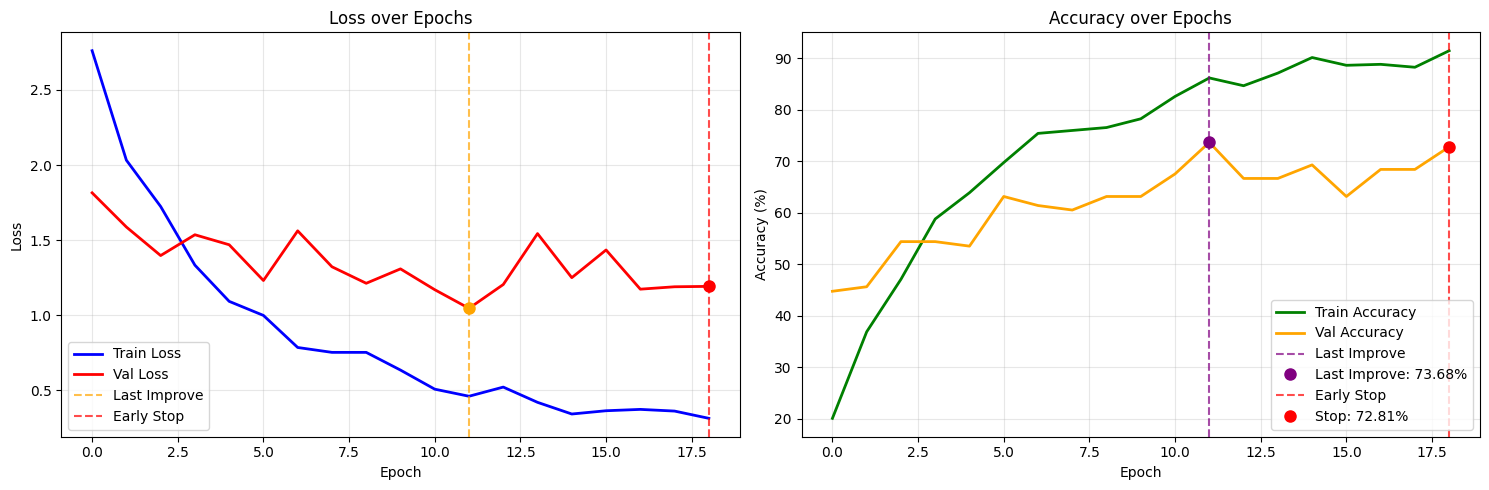

In [43]:
plot_training_history(
    train_losses, val_losses, train_accs, val_accs,
    early_stop_epoch=19,
    patience_start_epoch=12,
    patience_start_acc=73.68,
    early_stop_acc=72.81
)


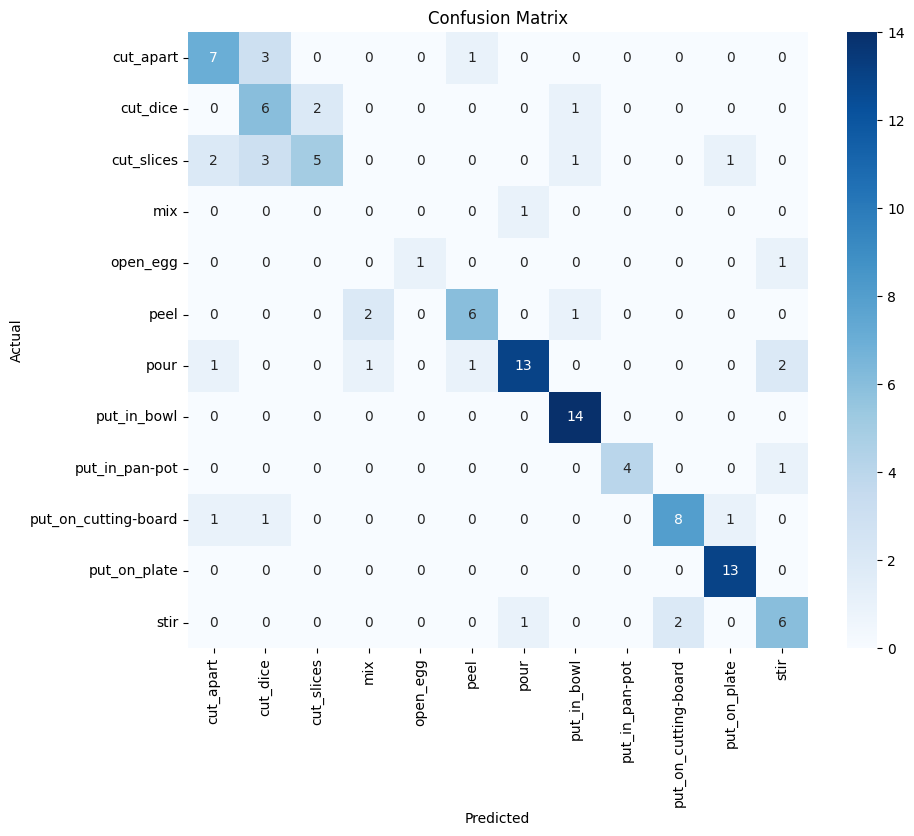


📊 Classification Report:
                      precision    recall  f1-score   support

           cut_apart       0.64      0.64      0.64        11
            cut_dice       0.46      0.67      0.55         9
          cut_slices       0.71      0.42      0.53        12
                 mix       0.00      0.00      0.00         1
            open_egg       1.00      0.50      0.67         2
                peel       0.75      0.67      0.71         9
                pour       0.87      0.72      0.79        18
         put_in_bowl       0.82      1.00      0.90        14
      put_in_pan-pot       1.00      0.80      0.89         5
put_on_cutting-board       0.80      0.73      0.76        11
        put_on_plate       0.87      1.00      0.93        13
                stir       0.60      0.67      0.63         9

            accuracy                           0.73       114
           macro avg       0.71      0.65      0.67       114
        weighted avg       0.76      0.73 

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, dataloader, encoder, device):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.permute(0,2,1,3,4).to(device)
            fast_inputs = inputs
            slow_inputs = inputs[:, :, ::4, :, :]
            
            outputs = model([slow_inputs, fast_inputs])
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    unique_labels = np.unique(all_labels)
    actual_classes = [encoder.classes_[i] for i in unique_labels]
    
    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=actual_classes, yticklabels=actual_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=actual_classes, labels=unique_labels))

plot_confusion_matrix(trained_model, val_loader, train_dataset.encoder, device)
